313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision History: [0.9492593502174663, 0.9654523507206275, 0.9684707020382343, 0.9702858202832289, 0.9722537912660606, 0.9747978918739005, 0.9737891363146287, 0.9724105681010298, 

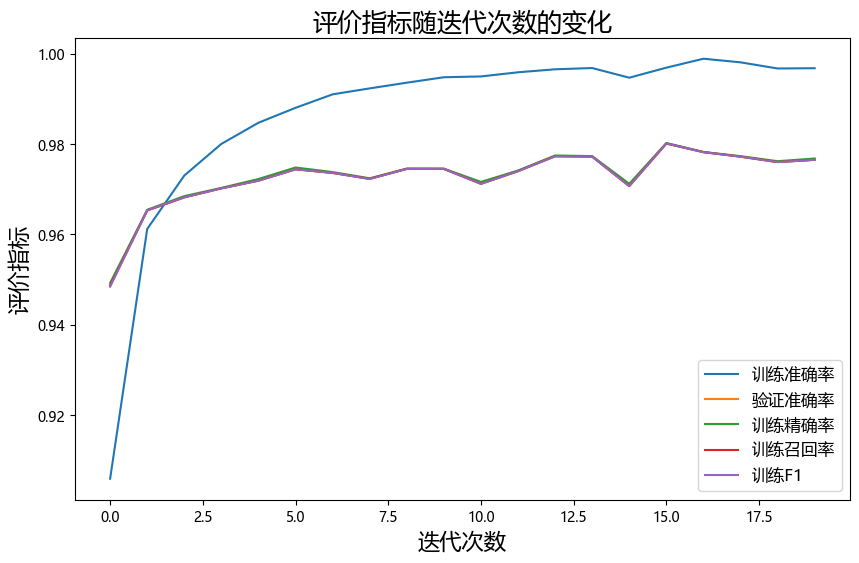

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import idx2numpy
from sklearn.metrics import precision_score, recall_score, f1_score

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑(避免出现某些中文显示不了的情况)

# 加载数据
train_images = idx2numpy.convert_from_file(r'D:\OneDrive\桌面\database\train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file(r'D:\OneDrive\桌面\database\train-labels.idx1-ubyte')
test_images = idx2numpy.convert_from_file(r'D:\OneDrive\桌面\database\t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file(r'D:\OneDrive\桌面\database\t10k-labels.idx1-ubyte')

# 数据预处理
np.random.seed(1)
#使所有的数据范围都集中在0到1
train_images, test_images = train_images / 255, test_images / 255

index = np.arange(len(train_images))
np.random.shuffle(index)

valid_images, valid_labels = train_images[index[-10000:]], train_labels[index[-10000:]]  # 验证数据
train_images, train_labels = train_images[index[:50000]], train_labels[index[:50000]]  # 训练数据

# 建立全连接神经网络
mnist_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 自定义评价指标函数
def precision(y_true, y_pred):
    precisions = []
    for label in np.unique(y_true):
        true_positives = np.sum((y_true == label) & (y_pred == label))
        predicted_positives = np.sum(y_pred == label)
        precision = true_positives / (predicted_positives + 1e-10)
        precisions.append(precision)
    
    # 计算每个类别的样本数量
    class_counts = [np.sum(y_true == label) for label in np.unique(y_true)]
    
    # 计算加权精确度
    weighted_precision = np.average(precisions, weights=class_counts)
    
    return weighted_precision

def recall(y_true, y_pred):
    recalls = []
    for label in np.unique(y_true):
        true_positives = np.sum((y_true == label) & (y_pred == label))
        actual_positives = np.sum(y_true == label)
        recall = true_positives / (actual_positives + 1e-10)
        recalls.append(recall)
    class_counts = np.bincount(y_true)
    weighted_recall = np.average(recalls, weights=class_counts)
    return weighted_recall

def f1_score_val(y_true, y_pred):
    f1_scores = []
    for label in np.unique(y_true):
        true_positives = np.sum((y_true == label) & (y_pred == label))
        actual_positives = np.sum(y_true == label)
        predicted_positives = np.sum(y_pred == label)
        precision = true_positives / (predicted_positives + 1e-10)
        recall = true_positives / (actual_positives + 1e-10)
        f1 = 2 * ((precision * recall) / (precision + recall + 1e-10))
        f1_scores.append(f1)
    class_counts = np.bincount(y_true)
    weighted_f1 = np.average(f1_scores, weights=class_counts)
    return weighted_f1

# 自定义回调函数来计算评价指标历史值
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(valid_images), axis=1)
        precision_val = precision(valid_labels, val_pred)
        recall_val = recall(valid_labels, val_pred)
        f1_val = f1_score_val(valid_labels, val_pred)
        
        self.precision_scores.append(precision_val)
        self.recall_scores.append(recall_val)
        self.f1_scores.append(f1_val)

# 编译模型时使用默认的评测指标，但添加自定义回调函数
mnist_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# 创建并使用回调函数来计算评价指标历史值
metrics_callback = MetricsCallback()

# 使用自定义回调函数训练模型
mnist_model_history = mnist_model.fit(train_images, train_labels, epochs=20, verbose=0,
                                      validation_data=(valid_images, valid_labels), batch_size=128,
                                      callbacks=[metrics_callback])

# 获取评价指标历史值
precision_history = metrics_callback.precision_scores
recall_history = metrics_callback.recall_scores
f1_score_history = metrics_callback.f1_scores

# 输出评价指标历史值
print('Precision History:', precision_history)
print('Recall History:', recall_history)
print('F1 Score History:', f1_score_history)

# 作出准确率、精确率、召回率和 F1 值随迭代次数变化的曲线图
plt.figure(figsize=(10, 6))

plt.plot(mnist_model_history.epoch, mnist_model_history.history['accuracy'], label="训练准确率")
plt.plot(mnist_model_history.epoch, mnist_model_history.history['val_accuracy'], label="验证准确率")
plt.plot(mnist_model_history.epoch, precision_history, label="训练精确率")
plt.plot(mnist_model_history.epoch, recall_history, label="训练召回率")
plt.plot(mnist_model_history.epoch, f1_score_history, label="训练F1")

plt.xlabel("迭代次数", fontsize=16)
plt.ylabel("评价指标", fontsize=16)
plt.legend(fontsize=12)
plt.title("评价指标随迭代次数的变化", fontsize=18)
plt.show()
